In [1]:
# Loading Test Images

import os
from PIL import Image
from pylab import *


all_images = {}
image_roots = [
    {
        "name": "DermQuest",
        "path": "DermQuest/"
    },
    {
        "name": "Dermofit",
        "path": "Dermofit/",
         "include_endswith": ".png",
         "exclude_contains": "mask"
    },
    {
        "name": "PH2Dataset",
        "path": "PH2Dataset/PH2 Dataset images",
        "include_endswith": ".bmp",
        "exclude_contains": "_"},
]


class ImageItem():
    def __init__(self, source, path):
        self.source = source
        self.path = path

    def get_image_data(self):
        if self.source == "DermQuest":
            # strip bottom copyright tag
            return array(Image.open(self.path))
        return array(Image.open(self.path))

    def __str__(self):
        return self.path


        # gather all images in all_image_root and store them in all_images
def gather_images():
    images = {}
    for root in image_roots:

        root_list = []

        if "include_endswith" in root and "exclude_contains" in root:
            for dirpath, dirnames, filenames in os.walk(root["path"]):
                for filename in [f for f in filenames if (f.endswith(root["include_endswith"]) and root["exclude_contains"] not in f)]:
                    root_list.append(
                        ImageItem(
                            path = os.path.join(dirpath, filename),
                            source = root['name']
                        )
                    )
        else:
            for dirpath, dirnames, filenames in os.walk(root["path"]):
                for filename in [f for f in filenames]:
                    root_list.append(
                        ImageItem(
                            path = os.path.join(dirpath, filename),
                            source = root['name']
                        )
                    )
        images[root["name"]] = root_list
    return images

all_images = gather_images()

In [35]:
from skimage.segmentation import slic
from skimage import img_as_ubyte
import cv2

def crop_to_center(image, scale=1.0):
    if scale == 1.0:
        return image
    else:
        height = int(image.shape[0] * scale)
        width = int(image.shape[1] * scale)
        top = int(image.shape[0] / 2) - int(height / 2)
        left = int(image.shape[1] / 2) - int(width / 2)

    return image[top:top + height, left:left + width]


def select_region_closest_to_center(mask, original, scale=1.0):
    mask = crop_to_center(mask, scale)
    original = crop_to_center(original, scale)

    # find all regions
    output = cv2.connectedComponentsWithStats(img_as_ubyte(mask), 4, cv2.CV_32S)
    regions = output[1]

    # find region closest to center
    center = (int(mask.shape[0] / 2), int(mask.shape[1] / 2))
    center_id = regions[center]
    region = regions == center_id
    kernel = np.ones((15, 15), np.uint8)
    region = cv2.dilate(img_as_ubyte(region), kernel, iterations=2)

    # get stats on center region
    output = cv2.connectedComponentsWithStats(img_as_ubyte(region), 4, cv2.CV_32S)
    stats = output[2]

    # calculate the distances from the image border
    distances_from_boundary = (
        stats[1][0],
        stats[1][1],
        stats[0][2] - (stats[1][0] + stats[1][2]),
        stats[0][3] - (stats[1][1] + stats[1][3]),
    )

    region = region[
             stats[1][1] - 10:stats[1][1] + stats[0][3] + 10,
             stats[1][0] - 10:stats[1][0] + stats[1][2] + 10
             ]
    original = original[
               stats[1][1] - 10:stats[1][1] + stats[0][3] + 10,
               stats[1][0] - 10:stats[1][0] + stats[1][2] + 10
               ]

    return region, original, distances_from_boundary


def find_border(image_original, region_scale=1.0, threshold=0.23):
    image = crop_to_center(image_original, region_scale)
    shape = image.shape

    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))  # Contrast Limited Adaptive Histogram Equalization
    v_eq = clahe.apply(image_hsv[:, :, 2])  # Apply Equalization to Value Channel of LAB image
    s_eq = clahe.apply(image_hsv[:, :, 1])

    image_hsv[:, :, 2] = v_eq
    image_hsv[:, :, 1] = s_eq

    # merged = v_eq * s_eq

    im = cv2.medianBlur(v_eq, 9)
    im = cv2.GaussianBlur(im, (21, 21), 0)

    size_index = 0
    increment = 5
    fudge = 0.0

    while size_index < threshold:
        ret, mask = cv2.threshold(im, fudge, 255, cv2.THRESH_BINARY)
        mask_size = bincount(mask.ravel())
        size_index = mask_size[0] / (shape[0] * shape[1])
        fudge = fudge + increment

    mask = 255 - mask
    distances_from_boundary = (100, 100, 100, 100)
    scale = 1.0

    while min(distances_from_boundary) > 50:
        region, cropped, distances_from_boundary = select_region_closest_to_center(mask, image, scale)
        scale -= 0.08

    ret, mask = cv2.threshold(img_as_ubyte(region), 1, 255, cv2.THRESH_BINARY)

    border = slic(cropped, n_segments=2, compactness=10, sigma=1)
    return border, mask, cropped, cv2.bitwise_and(cropped, cropped, mask=mask)




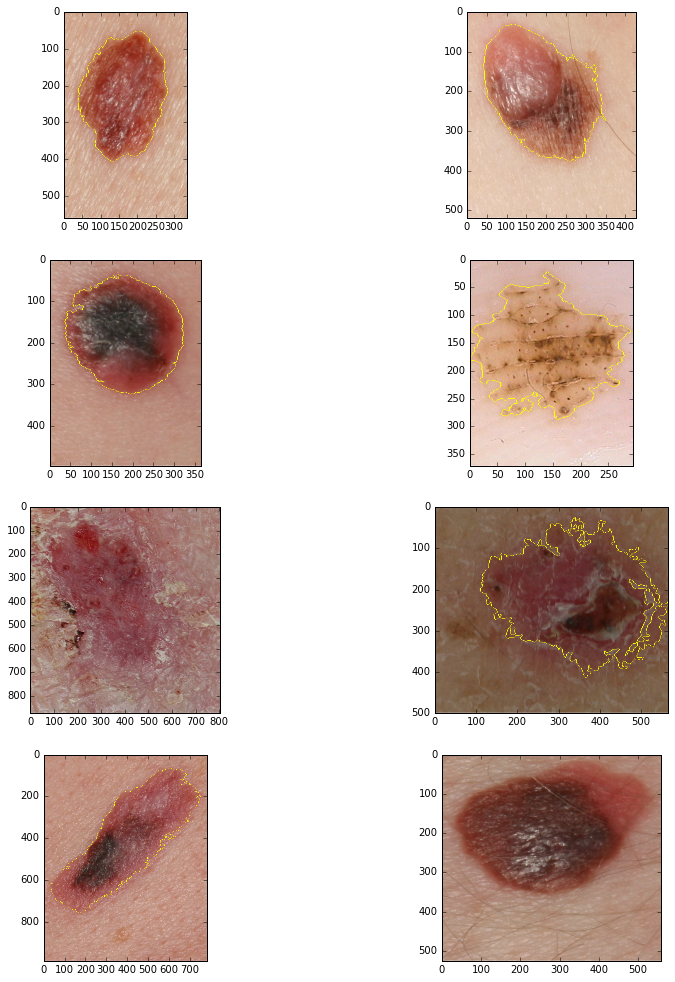

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

fig = plt.figure(figsize=(14, 24))

im = all_images["Dermofit"][537].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(421)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])

im = all_images["Dermofit"][539].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(422)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])


im = all_images["Dermofit"][541].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(423)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])


im = all_images["PH2Dataset"][12].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(424)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])


im = all_images["PH2Dataset"][4].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(424)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])

im = all_images["Dermofit"][520].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(425)
ax.imshow(mark_boundaries(cropped, border))
# ax.imshow(mask)
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])


im = all_images["Dermofit"][521].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(426)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])


im = all_images["Dermofit"][566].get_image_data()
border, mask, cropped, masked = find_border(im, region_scale=1.0, threshold=0.34)
ax = fig.add_subplot(427)
ax.imshow(mark_boundaries(cropped, border))
ax.axis([0, cropped.shape[1], cropped.shape[0], 0])



im = all_images["Dermofit"][570].get_image_data()
border, mask, cropped, masked = find_border(im)
ax = fig.add_subplot(428)
ax.imshow(mark_boundaries(cropped, border))
#ax.imshow(mask)

ax.axis([0, cropped.shape[1], cropped.shape[0], 0])


show()